In [44]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from holotomocupy.magnification import M
from holotomocupy.shift import S, ST, registration_shift
from holotomocupy.proc import remove_outliers
from holotomocupy.recon_methods import CTFPurePhase, multiPaganin
from holotomocupy.utils import *

%matplotlib inline

# Init data sizes and parametes of the PXM of ID16A

In [45]:
n = 2048
ntheta = 900
# ID16B setup
ndist = 1
fname = '/data/vnikitin/ESRF/ID16B/009/032_009_100nm'
fid = h5py.File(f'{fname}.h5','r')
z1 = fid['/instrument/z1'][:]
energy = fid['/instrument/energy'][()]
detector_pixelsize= fid['/instrument/detector_pixelsize'][()]
z12 = fid['/instrument/z12'][()]
sx0h = fid['/instrument/sx0h'][()]  
sx0v = fid['/instrument/sx0v'][()] 

wavelength = 1.2398419840550367e-09/energy 
sx0 = 0.5*(sx0h+sx0v)
z1 -= sx0
z2 = z12-z1
distances = (z1*z2)/z12
magnifications = z12/z1
voxelsize = detector_pixelsize/magnifications[0]*2048/n  # object voxel size

norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

z1p = z1[0]  # positions of the probe for reconstruction
z2p = z1-np.tile(z1p, len(z1))
# magnification when propagating from the probe plane to the detector
magnifications2 = (z1p+z2p)/z1p
# propagation distances after switching from the point source wave to plane wave,
distances2 = (z1p*z2p)/(z1p+z2p)
norm_magnifications2 = magnifications2/(z1p/z1[0])  # normalized magnifications
# scaled propagation distances due to magnified probes
distances2 = distances2*norm_magnifications2**2
distances2 = distances2*(z1p/z1)**2

# allow padding if there are shifts of the probe
pad = n//16
# sample size after demagnification
ne = int(np.ceil((n+2*pad)/norm_magnifications[-1]/8))*8  # make multiple of 8
print(f"{voxelsize=}")
show = True

voxelsize=9.993407856615017e-08


In [46]:
data0 = np.zeros([ntheta,ndist,n,n],dtype='float32')
ref0 = np.zeros([20,ndist,n,n],dtype='float32')
ref1 = np.zeros([20,ndist,n,n],dtype='float32')
dark0 = np.zeros([1,ndist,n,n],dtype='float32')

for k in range(ndist):
    data0[:,k] = fid[f'/exchange/data{k}'][:ntheta]
    ref0[:,k] = fid[f'/exchange/data{k}_white0']
    ref1[:,k] = fid[f'/exchange/data{k}_white1']
    dark0[:,k] = fid[f'/exchange/data{k}_dark']


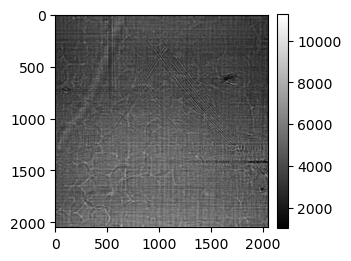

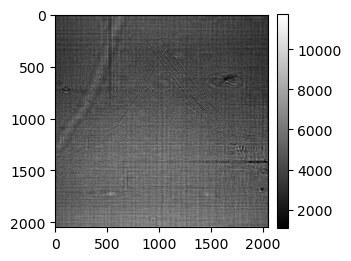

In [47]:
# remove outliers
for k in range(ndist):
    radius = 7
    threshold = 20000
    data0[:,k] = remove_outliers(data0[:,k], radius, threshold)
    ref0[:,k] = remove_outliers(ref0[:,k], radius, threshold)        
    ref1[:,k] = remove_outliers(ref0[:,k], radius, threshold)        

for k in range(ndist):
    mshow(data0[0,k],show)
for k in range(ndist):
    mshow(ref0[0,k],show)

## Take mean for flat and dark

In [48]:
ref0 = np.mean(ref0,axis=0)[np.newaxis]
dark0 = np.mean(dark0,axis=0)[np.newaxis]

### Normalize everything wrt to the mean of the reference image

In [49]:
mean_value = np.mean(ref0)
dark00 = dark0.astype('float32')/mean_value
ref00 = ref0.astype('float32')/mean_value
data00 = data0.astype('float32')/mean_value

data00 = data00-np.mean(dark00,axis=0)
ref00 = ref00-np.mean(dark00,axis=0)

data00[data00<0] = 0
ref00[ref00<0] = 0

# Find shifts of reference images

In [50]:
shifts_ref0 = np.zeros([1, ndist, 2], dtype='float32')
for k in range(ndist):
    shifts_ref0[:, k] = registration_shift(ref00[:, k], ref00[:, 0], upsample_factor=1000)
print(f'Found shifts: \n{shifts_ref0=}')

shifts_ref = np.zeros([ntheta, ndist, 2], dtype='float32')
for k in range(ndist):
    im = np.tile(ref00[0, 0], [ntheta, 1, 1])
    shifts_ref[:, k] = registration_shift(data00[:, k], im, upsample_factor=1000)  
print(f'Found shifts: \n{shifts_ref=}')


Found shifts: 
shifts_ref0=array([[[0., 0.]]], dtype=float32)
Found shifts: 
shifts_ref=array([[[-0.014, -0.077]]], dtype=float32)


### Assuming the shifts are calculated, shifts refs back

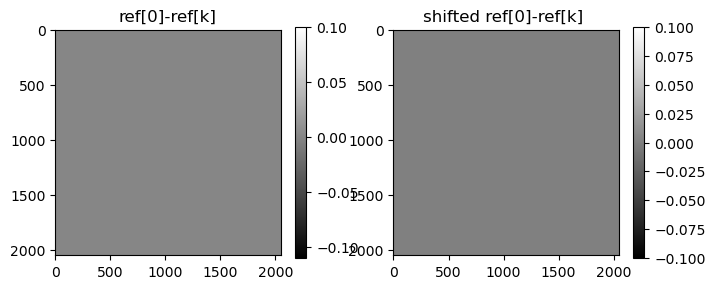

In [51]:
data0 = data00.copy()
ref0 = ref00.copy()
# shifted refs for correction
for k in range(ndist):
    # shift refs back
    ref0[:, k] = ST(ref0[:, k].astype('complex64'), shifts_ref0[:, k]).real

ref0c = np.tile(np.array(ref0), (ntheta, 1, 1, 1))
for k in range(ndist):
    # shift refs the position where they were when collecting data
    ref0c[:, k] = S(ref0c[:, k].astype('complex64'), shifts_ref[:, k]).real

for k in range(ndist):    
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    im = axs[0].imshow(ref00[0, 0]-ref00[0, k], cmap='gray',vmax=.1,vmin=-.11)
    axs[0].set_title('ref[0]-ref[k]')
    fig.colorbar(im)
    # ,vmin=-500,vmax=500)
    im = axs[1].imshow(ref0[0, 0]-ref0[0, k], cmap='gray',vmax=.1,vmin=-.1)
    axs[1].set_title('shifted ref[0]-ref[k] ')
    fig.colorbar(im)

### divide data by the reference image

In [52]:
rdata = data0/(ref0c+1e-9)

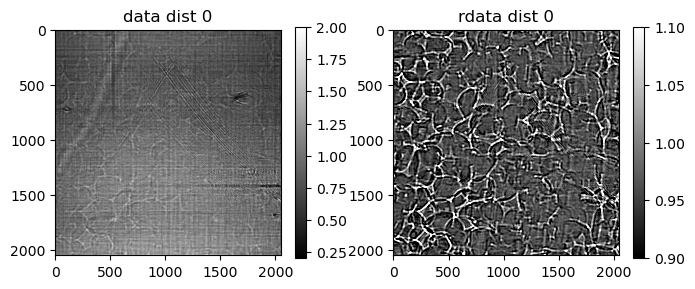

In [53]:
for k in range(ndist):
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    im=axs[0].imshow(data0[0,k],cmap='gray',vmax=2)
    axs[0].set_title(f'data dist {k}')
    fig.colorbar(im)
    im=axs[1].imshow(rdata[0,k],cmap='gray',vmax=1.1,vmin=0.9)
    axs[1].set_title(f'rdata dist {k}')
    fig.colorbar(im)

### Scale images

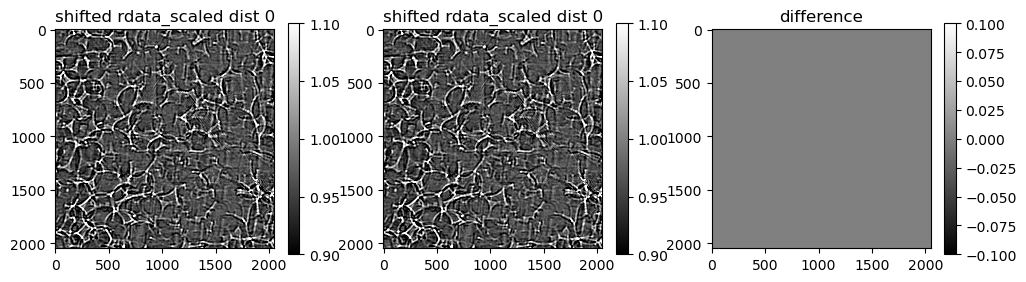

In [54]:
rdata_scaled = rdata.copy()

for k in range(ndist):
    rdata_scaled[:, k] = M(rdata_scaled[:, k], 1/norm_magnifications[k], n).real

for k in range(ndist):
    fig, axs = plt.subplots(1, 3, figsize=(12, 3))
    im = axs[0].imshow(rdata_scaled[0, 0], cmap='gray', vmin=0.9, vmax=1.1)
    axs[0].set_title(f'shifted rdata_scaled dist {k}')
    fig.colorbar(im)
    im = axs[1].imshow(rdata_scaled[0, k], cmap='gray', vmin=0.9, vmax=1.1)
    axs[1].set_title(f'shifted rdata_scaled dist {k}')
    fig.colorbar(im)
    im = axs[2].imshow(rdata_scaled[0, k]-rdata_scaled[0, 0], cmap='gray', vmin=-0.1, vmax=0.1)
    axs[2].set_title(f'difference')
    fig.colorbar(im)

### Align images between different planes


#### Approach 1. Align data

In [55]:
# shifts_drift = np.zeros([ntheta,ndist,2],dtype='float32')

# for k in range(1,ndist):
#     shifts_drift[:,k] = registration_shift(rdata_scaled[:,k],rdata_scaled[:,0],upsample_factor=1000)

# # note shifts_drift should be after magnification.
# shifts_drift*=norm_magnifications[np.newaxis,:,np.newaxis]

# shifts_drift_median = shifts_drift.copy()
# shifts_drift_median[:] = np.median(shifts_drift,axis=0)

# print(shifts_drift_median[0],shifts_drift_init[0])
# for k in range(ndist):
#     fig, axs = plt.subplots(1, 2, figsize=(10, 3))
#     im=axs[0].plot(shifts_drift[:,k,0],'.')
#     im=axs[0].plot(shifts_drift_median[:,k,0],'.')
#     im=axs[0].plot(shifts_drift_init[:,k,0],'r.')
#     axs[0].set_title(f'distance {k}, shifts y')
#     im=axs[1].plot(shifts_drift[:,k,1],'.')
#     im=axs[1].plot(shifts_drift_median[:,k,1],'.')
#     im=axs[1].plot(shifts_drift_init[:,k,1],'r.')
#     axs[1].set_title(f'distance {k}, shifts x')
#     # plt.show()

#### Approach 2. Align CTF reconstructions from 1 distance

[0.09165187] 9.993407856615017e-08


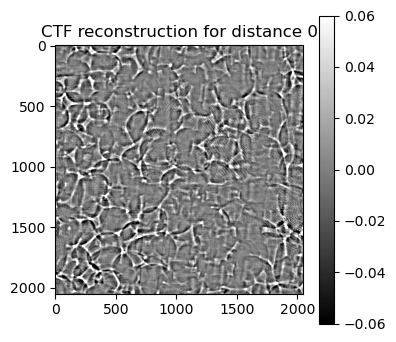

Found shifts: 
shifts_drift=array([[[0., 0.]]], dtype=float32)


In [56]:
recCTF_1dist = np.zeros([ntheta, ndist, n, n], dtype='float32')
distances_ctf = (distances/norm_magnifications**2)[:ndist]
print(distances_ctf,voxelsize)
for k in range(ndist):
    recCTF_1dist[:, k] = CTFPurePhase(
        rdata_scaled[:, k:k+1], distances_ctf[k:k+1], wavelength, voxelsize, 1e-1)

plt.figure(figsize=(4, 4))
plt.title(f'CTF reconstruction for distance {ndist-1}')
plt.imshow(recCTF_1dist[0, -1], cmap='gray',vmax=0.06,vmin=-0.06)
plt.colorbar()
plt.show()

shifts_drift = np.zeros([ntheta, ndist, 2], dtype='float32')

for k in range(1, ndist):
    shifts_drift[:, k] = registration_shift(
        recCTF_1dist[:, k], recCTF_1dist[:, 0], upsample_factor=1000)

# note shifts_drift should be after magnification.
shifts_drift *= norm_magnifications[np.newaxis, :, np.newaxis]

    
print(f'Found shifts: \n{shifts_drift=}')


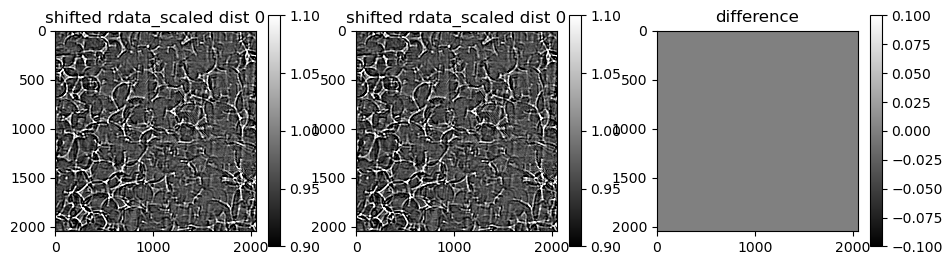

In [57]:
rdata_scaled_aligned = rdata_scaled.copy()
for k in range(ndist):
    rdata_scaled_aligned[:, k] = ST(rdata_scaled[:, k], shifts_drift[:, k]/norm_magnifications[k]).real
    
for k in range(ndist):
    fig, axs = plt.subplots(1, 3, figsize=(11, 3))
    im = axs[0].imshow(rdata_scaled_aligned[0, 0], cmap='gray', vmin=.9, vmax=1.1)
    axs[0].set_title(f'shifted rdata_scaled dist {k}')
    fig.colorbar(im)
    im = axs[1].imshow(rdata_scaled_aligned[0, k], cmap='gray', vmin=.9, vmax=1.1)
    axs[1].set_title(f'shifted rdata_scaled dist {k}')
    fig.colorbar(im)
    im = axs[2].imshow(rdata_scaled_aligned[0, k] - rdata_scaled_aligned[0, 0], cmap='gray', vmin=-0.1, vmax=.1)
    axs[2].set_title(f'difference')
    fig.colorbar(im)

#### Reconstruction by the MultiPaganin method

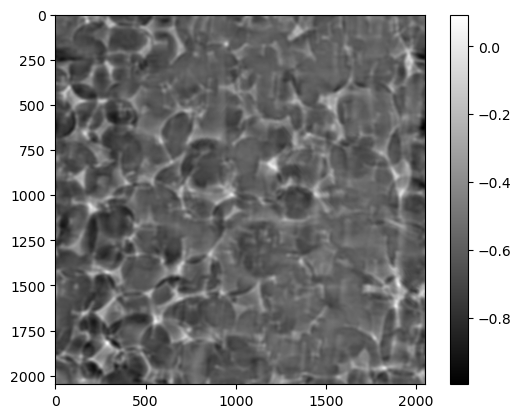

In [58]:
# distances should not be normalized
distances_pag = (distances/norm_magnifications**2)[:ndist]
recMultiPaganin = multiPaganin(rdata_scaled_aligned, distances_pag, wavelength, voxelsize, 30, 1e-12)
plt.imshow(recMultiPaganin[0],cmap='gray')
plt.colorbar()

#### Reconstruction by the CTF pure phase method

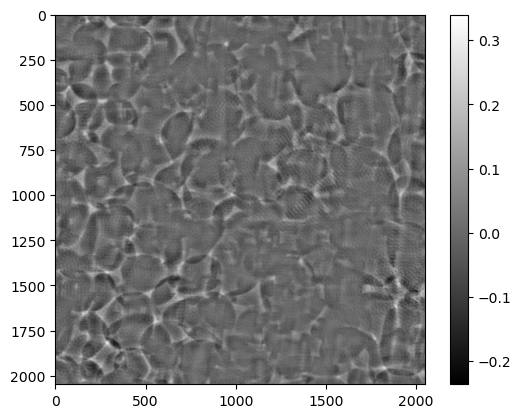

In [59]:
distances_ctf = (distances/norm_magnifications**2)[:ndist]

recCTF = CTFPurePhase(rdata_scaled_aligned, distances_ctf, wavelength, voxelsize, 1e-2)
plt.imshow(recCTF[0],cmap='gray')
plt.colorbar()
plt.show()


In [65]:
import h5py
import os
os.system(f'mkdir {fname}_rec')
os.system(f'mkdir {fname}_rec/recmultiPaganin/')
os.system(f'mkdir {fname}_rec/recCTF/')
with h5py.File(f'{fname}_rec/recmultiPaganin/r.h5','w') as fid:
    fid.create_dataset('/exchange/data',data = recMultiPaganin)
    fid.create_dataset('/exchange/data_white',data = np.ones([1,*recMultiPaganin.shape[1:]],dtype='float32'))
    fid.create_dataset('/exchange/data_dark',data = np.zeros([1,*recMultiPaganin.shape[1:]],dtype='float32'))
    fid.create_dataset('/exchange/theta',data = np.linspace(0,360,ntheta).astype('float32'))

with h5py.File(f'{fname}_rec/recCTF/r.h5','w') as fid:
    fid.create_dataset('/exchange/data',data = recCTF)
    fid.create_dataset('/exchange/data_white',data = np.ones([1,*recMultiPaganin.shape[1:]],dtype='float32'))
    fid.create_dataset('/exchange/data_dark',data = np.zeros([1,*recMultiPaganin.shape[1:]],dtype='float32'))
    fid.create_dataset('/exchange/theta',data = np.linspace(0,360,ntheta).astype('float32'))


mkdir: cannot create directory ‘/data/vnikitin/ESRF/ID16B/009/032_009_100nm_rec’: File exists
mkdir: cannot create directory ‘/data/vnikitin/ESRF/ID16B/009/032_009_100nm_rec/recmultiPaganin/’: File exists
mkdir: cannot create directory ‘/data/vnikitin/ESRF/ID16B/009/032_009_100nm_rec/recCTF/’: File exists
